![Business Intelligence Banner](https://img.freepik.com/premium-vector/business-intelligence-implementation-word-concepts-dark-blue-banner_106317-24117.jpg?w=826)

Al entregar la solución de este parcial, yo, **David Mateo Barbosa Monsalve** con código **202110756** me comprometo a no conversar durante el desarrollo de este examen con ninguna persona que no sea el profesor del curso, sobre aspectos relacionados con el parcial; tampoco utilizaré algún medio de comunicación por voz, texto o intercambio de archivos, para consultar o compartir con otros, información sobre el tema del parcial. Ni usaré alguna IA para resolver las preguntas del parcial. Soy consciente y acepto las consecuencias que acarreará para mi desempeño académico cometer fraude en este parcial.

# Environment Setup

In [31]:
! pip install pandas-profiling

In [32]:
# These imports are for readability and do not directly affect the functioning of the code (only type-hints)
from __future__ import annotations

from typing_extensions import *
from typing import *

In [ ]:
# Some features are deprecated
__import__('warnings').filterwarnings('ignore')

In [33]:
import os
import operator as op
import functools
import itertools
import collections

import matplotlib.pyplot as plt
import tabulate as tb
import seaborn as sns
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
    Normalizer
)

MODEL: Final[Literal['CLASSIFICATION', 'CLUSTERING', 'REGRESSION']] = 'REGRESSION'

match MODEL:
    case 'CLASSIFICATION':
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score, classification_report
    case 'CLUSTERING':
        from sklearn.decomposition import PCA
        from sklearn.cluster import KMeans
        from sklearn.mixture import GaussianMixture
        from sklearn.metrics import silhouette_score
    case 'REGRESSION':
        from sklearn.linear_model import LinearRegression
        from sklearn.svm import SVR
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import mean_squared_error, r2_score
    case _:
        assert_never(MODEL)

In [34]:
sns.set()

In [35]:
# Url referencing the public repository to facilitate data fetching
GITHUB_URL: Final[str] = 'https://raw.githubusercontent.com/DavidMateoBarbosa/BI-Exam-01/main'

In [36]:
dataset: Final[pd.DataFrame] = pd.read_csv(os.path.join(GITHUB_URL, 'dataset.csv'), delimiter=';', encoding='latin-1')

# Data Profiling

In [37]:
# ProfileReport(dataset)

In [38]:
dataset.describe()

,IdCliente,Antiguedad,PromMinUsadosDia,PromNumLlamadasDia,PromMinUsadosTarde,PromNumLlamadasTarde,PromMinUsadosNoche,PromNumLlamadasNoche
count,3.0,3.00000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,2.0,107.00000,178.800000,121.666667,212.233333,97.000000,208.833333,118.333333
std,1.0,50.86256,94.155244,6.658328,3.231615,27.712813,29.747997,10.016653
min,1.0,70.00000,70.700000,114.000000,209.800000,65.000000,174.600000,107.000000
25%,1.5,78.00000,146.750000,119.500000,210.400000,89.000000,199.050000,114.500000
50%,2.0,86.00000,222.800000,125.000000,211.000000,113.000000,223.500000,122.000000
75%,2.5,125.50000,232.850000,125.500000,213.450000,113.000000,225.950000,124.000000
max,3.0,165.00000,242.900000,126.000000,215.900000,113.000000,228.400000,126.000000


In [39]:
dataset

,IdCliente,Ciudad,Antiguedad,PlanInternacional,BuzonDeVoz,PromMinUsadosDia,PromNumLlamadasDia,PromMinUsadosTarde,PromNumLlamadasTarde,PromMinUsadosNoche,PromNumLlamadasNoche
0,1,Bogotá,86,Si,No,70.7,125,211.0,113,174.6,107
1,2,Cali,165,No,Si,242.9,126,209.8,65,228.4,126
2,3,Medellin,70,No,Si,222.8,114,215.9,113,223.5,122


## Data Quality Analysis

### Completeness

In [40]:
completeness: list[tuple[str, int]] = [(column, dataset[column].isna().sum()) for column in dataset.columns]
print(tb.tabulate(completeness, headers=['Column Name', 'Missing Values'], tablefmt='outline'))

+----------------------+------------------+
| Column Name          |   Missing Values |
+======================+==================+
| IdCliente            |                0 |
| Ciudad               |                0 |
| Antiguedad           |                0 |
| PlanInternacional    |                0 |
| BuzonDeVoz           |                0 |
| PromMinUsadosDia     |                0 |
| PromNumLlamadasDia   |                0 |
| PromMinUsadosTarde   |                0 |
| PromNumLlamadasTarde |                0 |
| PromMinUsadosNoche   |                0 |
| PromNumLlamadasNoche |                0 |
+----------------------+------------------+


In [41]:
incomplete: list[str] = [column for column, missings in completeness if missings > 0]
if incomplete:
    print('It can be seen how the %s features have missing values.' % incomplete)
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


### Uniqueness

In [42]:
uniqueness: list[tuple[str, int]] = [(column, dataset[column].nunique() == len(dataset[column])) for column in dataset.columns]
print(tb.tabulate(uniqueness, headers=['Column Name', 'Has Uniqueness'], tablefmt='outline'))

+----------------------+------------------+
| Column Name          | Has Uniqueness   |
+======================+==================+
| IdCliente            | True             |
| Ciudad               | True             |
| Antiguedad           | True             |
| PlanInternacional    | False            |
| BuzonDeVoz           | False            |
| PromMinUsadosDia     | True             |
| PromNumLlamadasDia   | True             |
| PromMinUsadosTarde   | True             |
| PromNumLlamadasTarde | False            |
| PromMinUsadosNoche   | True             |
| PromNumLlamadasNoche | True             |
+----------------------+------------------+


In [43]:
duplicates: list[str] = [column for column, unique in uniqueness if not unique]
if duplicates:
    print('It can be seen how the %s features have duplicate values.' % duplicates)
else:
    print('There are no duplicate values in the dataset.')

It can be seen how the ['PlanInternacional', 'BuzonDeVoz', 'PromNumLlamadasTarde'] features have duplicate values.


While it is true that duplicate data may occur in certain features, not all features allow this due to the nature of the features.

### Consistency

### Validity

# Data Preparation

In [44]:
# Copy the original dataset to avoid modifying it directly
train_dataset: pd.DataFrame = dataset.copy()

## Adjustments

In [45]:
def relevantizer(dataset: pd.DataFrame, excluded: list[str]) -> pd.DataFrame:
    """
    Removes columns from the DataFrame that are specified in the excluded list.

    :param dataset: pd.DataFrame
        The DataFrame containing the data to be filtered.
    :param excluded: list of str
        List of column names to be excluded from the DataFrame.
    :return: pd.DataFrame
        A new DataFrame with the excluded columns removed.
    """
    # Drop the columns that are in the excluded list
    return dataset.drop(columns=excluded, errors='ignore')

In [46]:
train_dataset = relevantizer(train_dataset, ['IdCliente'])

In [47]:
def booleanize(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Converts columns with only two unique non-null values to boolean type.

    :param dataset: pd.DataFrame
        The DataFrame to be converted.
    :return: pd.DataFrame
        A DataFrame with binary columns converted to boolean type.
    """
    for column in dataset.columns:
        unique = dataset[column].dropna().unique()
        if len(unique) == 2:
            # Map the unique values to False and True
            dataset[column] = dataset[column].map({unique[0]: False, unique[1]: True})
    return dataset

In [48]:
train_dataset = booleanize(train_dataset)

In [49]:
def normalize(dataset: pd.DataFrame, method: str = 'standard') -> pd.DataFrame:
    """
    Normalizes the DataFrame using the specified method without modifying the original dataset.

    :param dataset: pd.DataFrame
        The DataFrame containing the data to be normalized.
    :param method: str, optional
        The normalization method to use. Default is 'standard'.
        Options: 'standard', 'minmax', 'robust', 'maxabs', 'normalize'.
    :return: pd.DataFrame
        A DataFrame with normalized values.
    """
    scalers = {
        'standard': StandardScaler(),
        'minmax': MinMaxScaler(),
        'robust': RobustScaler(),
        'maxabs': MaxAbsScaler(),
        'normalize': Normalizer()
    }

    if method not in scalers:
        raise ValueError(f"Invalid normalization method: {method}. Choose from {list(scalers.keys())}.")

    # Use only numerical columns and exclude boolean and One-Hot columns from normalization
    columns_to_normalize = dataset.select_dtypes(include=[np.number]).columns.difference(dataset.select_dtypes(include=[bool]).columns)
    dataset[columns_to_normalize] = scalers[method].fit_transform(dataset[columns_to_normalize])
    return dataset

In [50]:
train_dataset = normalize(train_dataset)

In [51]:
def onehotize(dataset: pd.DataFrame, columns: list[str] = None) -> pd.DataFrame:
    """
    Converts categorical columns in the DataFrame to one-hot encoded columns.

    :param dataset: pd.DataFrame
        The DataFrame containing the data to be one-hot encoded.
    :param columns: list[str], optional
        List of specific columns to be one-hot encoded. If None, all categorical columns will be encoded.
    :return: pd.DataFrame
        A new DataFrame with the specified columns one-hot encoded.
    """
    # If no specific columns are provided, select all object or category type columns
    if columns is None:
        columns = dataset.select_dtypes(include=['object', 'category']).columns

    # Use pd.get_dummies to one-hot encode the specified columns
    return pd.get_dummies(dataset, columns=columns, drop_first=False)


In [52]:
train_dataset = onehotize(train_dataset)

In [53]:
train_dataset

,Antiguedad,PlanInternacional,BuzonDeVoz,PromMinUsadosDia,PromNumLlamadasDia,PromMinUsadosTarde,PromNumLlamadasTarde,PromMinUsadosNoche,PromNumLlamadasNoche,Ciudad_Bogotá,Ciudad_Cali,Ciudad_Medellin
0,-0.505669,False,False,-1.406134,0.613139,-0.467419,False,-1.409409,-1.385737,True,False,False
1,1.396611,True,True,0.833795,0.797081,-0.922205,True,0.805573,0.937410,False,True,False
2,-0.890941,True,True,0.572340,-1.410220,1.389625,False,0.603836,0.448327,False,False,True


In [54]:
train_dataset.describe()

,Antiguedad,PromMinUsadosDia,PromNumLlamadasDia,PromMinUsadosTarde,PromMinUsadosNoche,PromNumLlamadasNoche
count,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
mean,-3.700743e-17,-4.440892e-16,-8.881784e-16,-3.626729e-15,-4.070818e-16,5.551115e-16
std,1.224745e+00,1.224745e+00,1.224745e+00,1.224745e+00,1.224745e+00,1.224745e+00
min,-8.909414e-01,-1.406134e+00,-1.410220e+00,-9.222054e-01,-1.409409e+00,-1.385737e+00
25%,-6.983054e-01,-4.168974e-01,-3.985406e-01,-6.948123e-01,-4.027864e-01,-4.687050e-01
50%,-5.056694e-01,5.723396e-01,6.131393e-01,-4.674192e-01,6.038364e-01,4.483265e-01
75%,4.454707e-01,7.030672e-01,7.051102e-01,4.611027e-01,7.047046e-01,6.928683e-01
max,1.396611e+00,8.337947e-01,7.970811e-01,1.389625e+00,8.055727e-01,9.374100e-01


In [55]:
train_dataset.dtypes

,0
Antiguedad,float64
PlanInternacional,bool
BuzonDeVoz,bool
PromMinUsadosDia,float64
PromNumLlamadasDia,float64
PromMinUsadosTarde,float64
PromNumLlamadasTarde,bool
PromMinUsadosNoche,float64
PromNumLlamadasNoche,float64
Ciudad_Bogotá,bool


In [56]:
train_dataset.shape

(3, 12)

## Selection

In [57]:
TARGETS: Final[list[str]] = ['PlanInternacional']

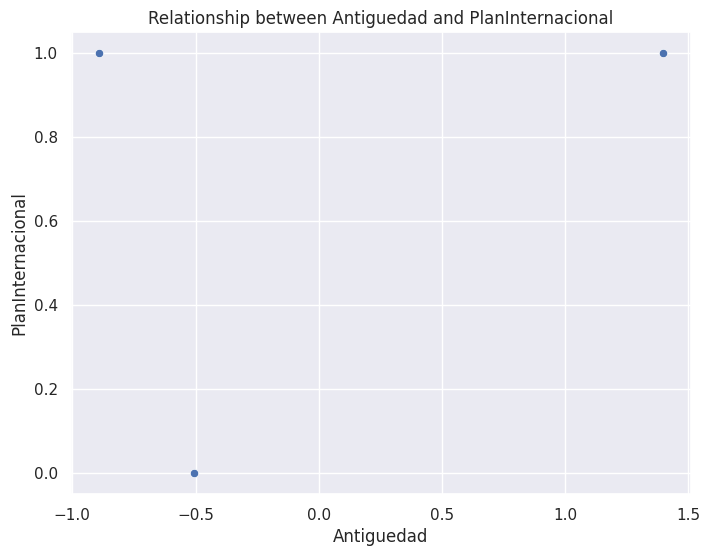

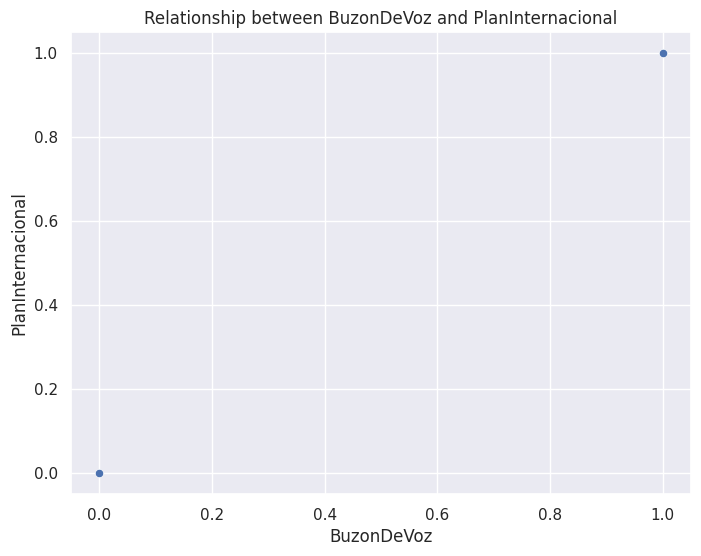

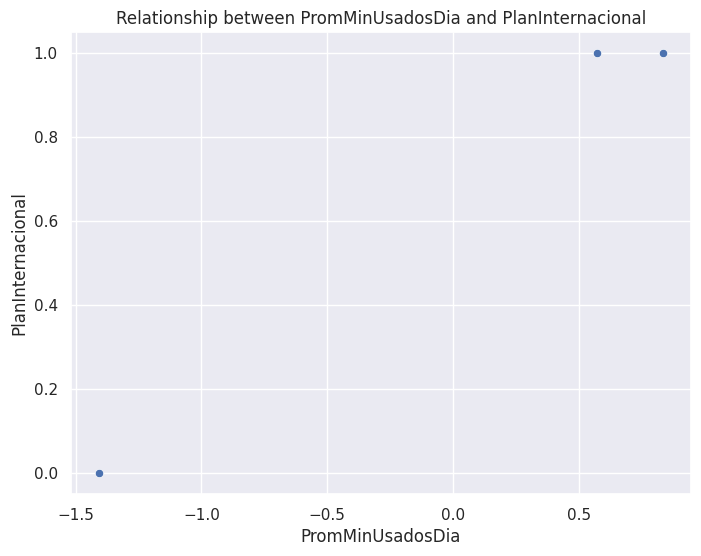

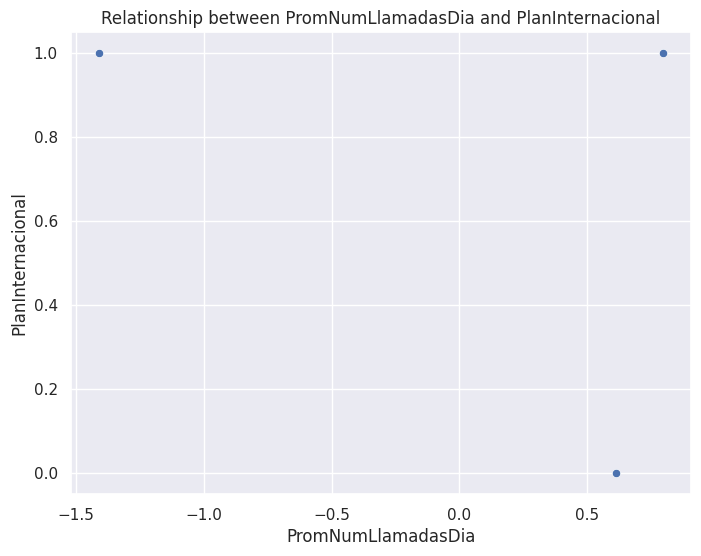

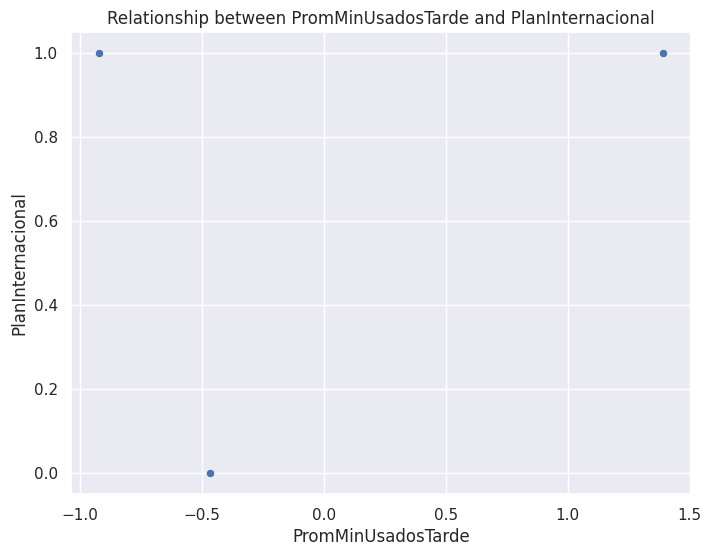

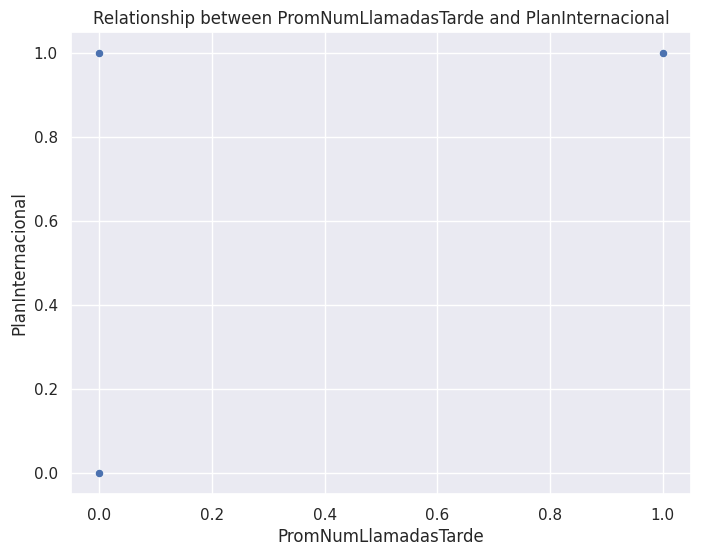

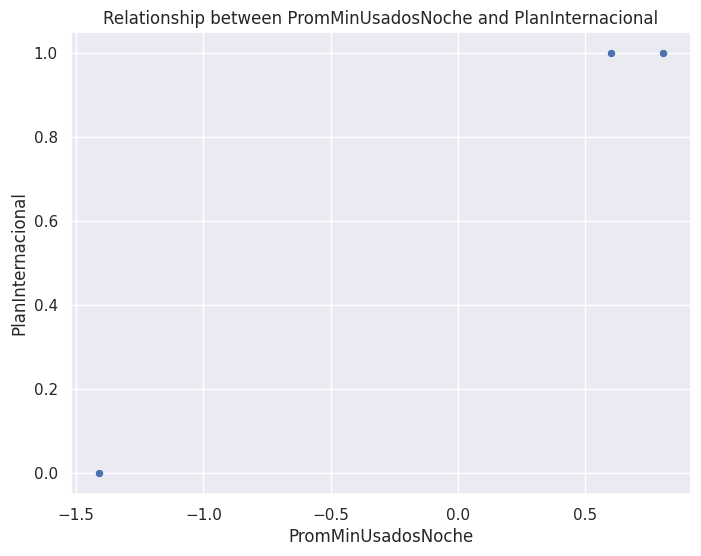

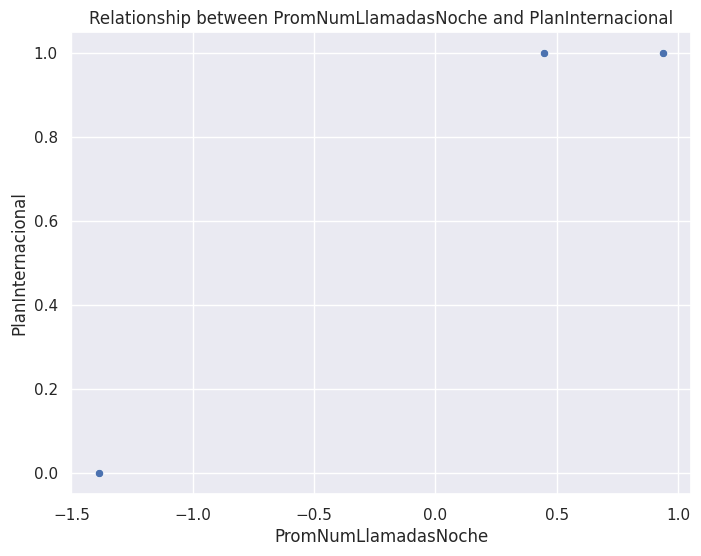

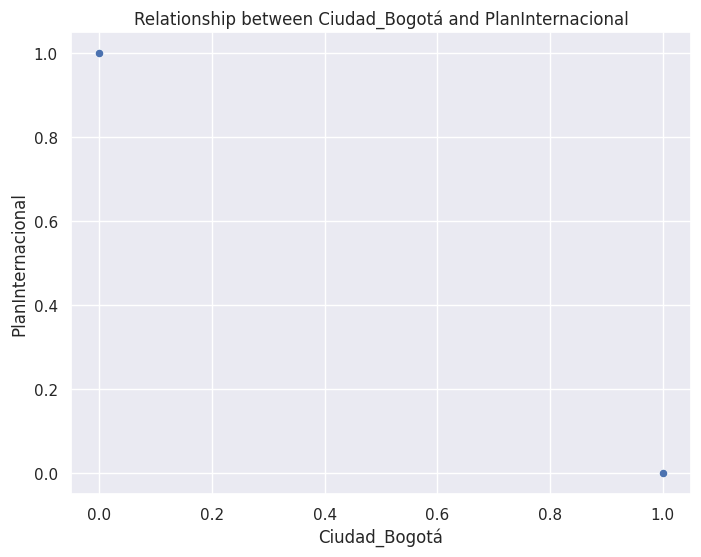

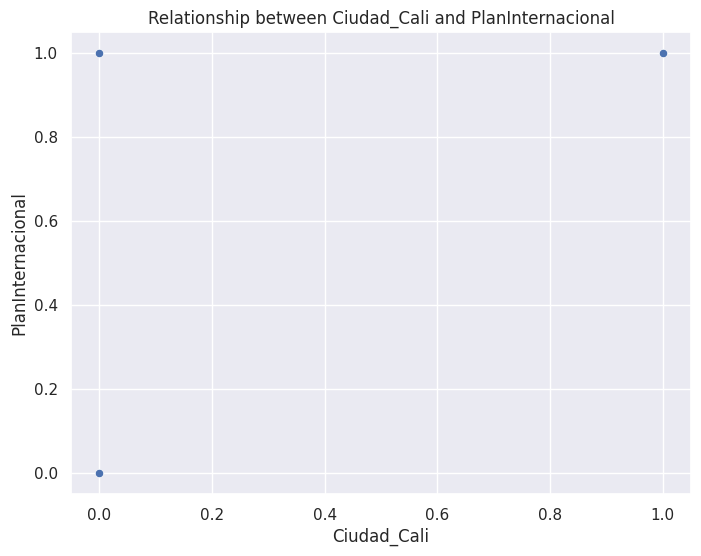

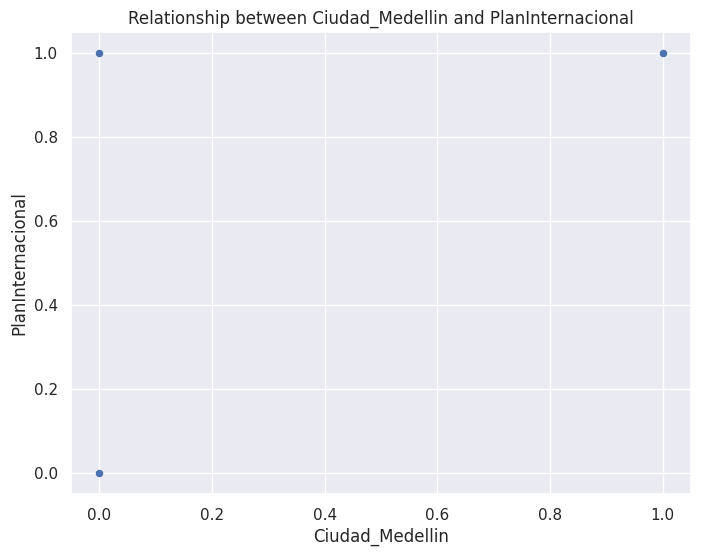

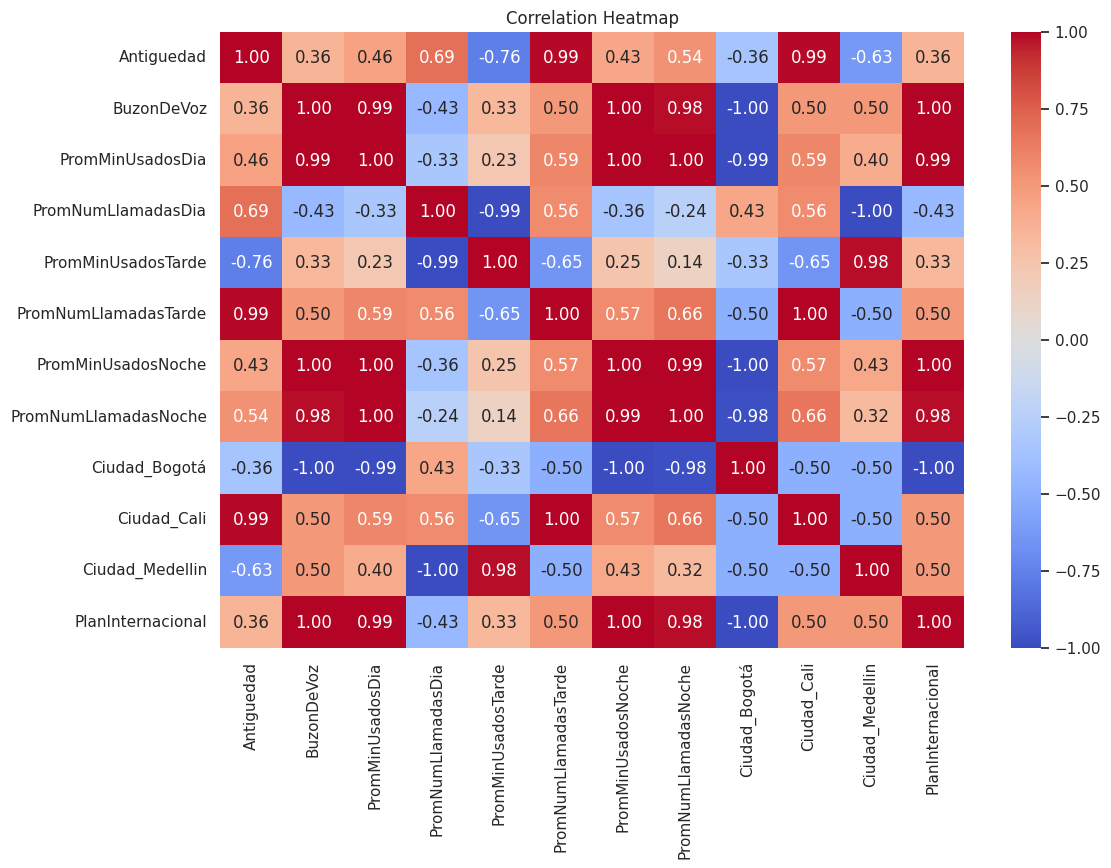

Suggested Hyperparameters (Regression): {'top_features': ['BuzonDeVoz', 'PromMinUsadosDia', 'PromMinUsadosNoche', 'PromNumLlamadasNoche', 'Ciudad_Bogotá']}


In [58]:
# Graphs to understand the data
match MODEL:
    case 'CLASSIFICATION':
        def data_analysing(x: pd.DataFrame, y: pd.DataFrame) -> None:
            """
            Generates visualizations to understand the distribution and relationships in classification data.

            :param x: pd.DataFrame
                The feature set.
            :param y: pd.DataFrame
                The target variables for classification.
            """
            for target in y.columns:
                # Pairplot for visualizing relationships between features and target
                combined = pd.concat([x, y[target]], axis=1)
                sns.pairplot(combined, hue=target, diag_kind='kde', corner=True)
                plt.suptitle(f'Pairplot of Features with Target: {target}', y=1.02)
                plt.show()

                # Class distribution for each target
                plt.figure(figsize=(6, 4))
                sns.countplot(data=y, x=target, palette='viridis')
                plt.title(f'Class Distribution for Target: {target}')
                plt.xlabel('Class')
                plt.ylabel('Count')
                plt.grid(axis='y')
                plt.show()

        def determine_hyperparameters(x: pd.DataFrame, y: pd.DataFrame) -> dict[str, Any]:
            """
            Determines relevant hyperparameters for classification models based on data analysis.

            :param x: pd.DataFrame
                The feature set.
            :param y: pd.DataFrame
                The target variables for classification.
            :return: dict
                A dictionary of suggested hyperparameters.
            """
            hyperparams = {}
            correlations = x.corrwith(y.squeeze())
            top_features = correlations.abs().nlargest(5).index.tolist()
            hyperparams['top_features'] = top_features
            return hyperparams

        data_analysing(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        hyperparameters = determine_hyperparameters(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        print("Suggested Hyperparameters (Classification):", hyperparameters)

    case 'CLUSTERING':
        def data_analysing(dataset: pd.DataFrame) -> None:
            """
            Generates visualizations to understand the distribution and relationships in clustering data.

            :param dataset: pd.DataFrame
                The dataset to be used for clustering analysis.
            """
            # PCA for visualizing clusters in 2D
            pca = PCA(n_components=2)
            pca_components = pca.fit_transform(dataset)
            explained_variance = pca.explained_variance_ratio_.sum()
            print(f'PCA Explained Variance: {explained_variance:.2f}')

            # Scatter plot for PCA components
            plt.figure(figsize=(10, 6))
            plt.scatter(pca_components[:, 0], pca_components[:, 1], alpha=0.5)
            plt.title('PCA Visualization of Features')
            plt.xlabel('PCA Component 1')
            plt.ylabel('PCA Component 2')
            plt.grid(True)
            plt.show()

            # Pairplot of the first few features to observe their distributions
            sns.pairplot(dataset.iloc[:, :5], corner=True)
            plt.suptitle('Pairplot of First Five Features', y=1.02)
            plt.show()

        def determine_hyperparameters(x: pd.DataFrame) -> Dict[str, Any]:
            """
            Determines relevant hyperparameters for clustering models based on data analysis.

            :param x: pd.DataFrame
                The dataset to be analyzed for clustering.
            :return: dict
                A dictionary of suggested hyperparameters.
            """
            distortions = []
            K = range(1, min(11, len(x)))  # The max number of clusters should be less than or equal to the number of samples

            for k in K:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')  # Set n_init to 'auto' to avoid future warnings
                kmeans.fit(x)
                distortions.append(kmeans.inertia_)

            # Find the elbow point using the difference in distortions
            optimal_clusters = np.argmax(np.diff(distortions)) + 1  # +1 to match cluster number

            # Ensure the optimal number of clusters is less than or equal to the number of samples
            optimal_clusters = min(optimal_clusters, len(x))

            return {'n_clusters': optimal_clusters}

        data_analysing(train_dataset.drop(columns=TARGETS))
        hyperparameters = determine_hyperparameters(train_dataset.drop(columns=TARGETS))
        print("Suggested Hyperparameters (Clustering):", hyperparameters)

    case 'REGRESSION':
        def data_analysing(x: pd.DataFrame, y: pd.Series | pd.DataFrame) -> None:
            """
            Generates visualizations to understand the relationships in regression data.

            :param x: pd.DataFrame
                The feature set.
            :param y: pd.Series | pd.DataFrame
                The target variable(s) for regression.
            """
            if isinstance(y, pd.Series):
                y = pd.DataFrame(y, columns=[y.name])

            # Scatter plot for each feature against target
            for target in y.columns:
                for feature in x.columns:
                    plt.figure(figsize=(8, 6))
                    sns.scatterplot(x=x[feature], y=y[target])
                    plt.title(f'Relationship between {feature} and {target}')
                    plt.xlabel(feature)
                    plt.ylabel(target)
                    plt.grid(True)
                    plt.show()

            # Correlation heatmap for the feature set
            correlation_matrix = pd.concat([x, y], axis=1).corr()
            plt.figure(figsize=(12, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
            plt.title('Correlation Heatmap')
            plt.show()

        def determine_hyperparameters(x: pd.DataFrame, y: pd.DataFrame, mincorr: float = 0.25) -> Dict[str, Any]:
            """
            Determines relevant hyperparameters for regression models based on data analysis.

            :param x: pd.DataFrame
                The feature set.
            :param y: pd.DataFrame
                The target variables for regression.
            :param mincorr: float
                The minimum absolute correlation value required for a feature to be selected.
            :return: dict
                A dictionary of suggested hyperparameters.
            """
            hyperparams = {}
            correlations = x.corrwith(y.squeeze())
            top_features = correlations[correlations.abs() > mincorr].index.tolist()
            hyperparams['top_features'] = top_features
            return hyperparams


        data_analysing(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        hyperparameters = determine_hyperparameters(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS], 0.5)
        print("Suggested Hyperparameters (Regression):", hyperparameters)
    case _:
        assert_never(MODEL)

# Building The Model

In [59]:
# Each model construction
match MODEL:
    case 'CLASSIFICATION':
        def build_model(x: pd.DataFrame, y: pd.DataFrame) -> Any:
            """
            Builds and trains classification models using determined hyperparameters.

            :param x: pd.DataFrame
                The feature set used for training.
            :param y: pd.DataFrame
                The target variable(s) for classification.
            :param hyperparameters: dict
                The determined hyperparameters for the models.
            :return: Trained classification models.
            """
            # Initialize the models with default hyperparameters or custom ones
            logistic_regression = LogisticRegression(max_iter=200)
            random_forest = RandomForestClassifier()

            # Training models
            logistic_regression.fit(x[hyperparameters['top_features']], y.squeeze())
            random_forest.fit(x[hyperparameters['top_features']], y.squeeze())

            # Return trained models
            return {'Logistic Regression': logistic_regression, 'Random Forest': random_forest}

        hyperparameters = determine_hyperparameters(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        models = build_model(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        print("Trained Models (Classification):", models)
    case 'CLUSTERING':
        def build_model(x: pd.DataFrame) -> Any:
            """
            Builds and trains clustering models using determined hyperparameters.

            :param x: pd.DataFrame
                The dataset used for clustering.
            :param hyperparameters: dict
                The determined hyperparameters for the models.
            :return: Trained clustering models.
            """
            # Initialize the models with determined number of clusters
            kmeans = KMeans(n_clusters=hyperparameters['n_clusters'], random_state=42, n_init='auto')
            gaussian_mixture = GaussianMixture(n_components=hyperparameters['n_clusters'], random_state=42)

            # Training models
            kmeans.fit(x)
            gaussian_mixture.fit(x)

            # Return trained models
            return {'KMeans': kmeans, 'Gaussian Mixture': gaussian_mixture}

        hyperparameters = determine_hyperparameters(train_dataset.drop(columns=TARGETS))
        models = build_model(train_dataset.drop(columns=TARGETS))
        print("Trained Models (Clustering):", models)
    case 'REGRESSION':
        def build_model(x: pd.DataFrame, y: pd.DataFrame) -> Any:
            """
            Builds and trains regression models using determined hyperparameters.

            :param x: pd.DataFrame
                The feature set used for training.
            :param y: pd.DataFrame
                The target variable(s) for regression.
            :param hyperparameters: dict
                The determined hyperparameters for the models.
            :return: Trained regression models.
            """
            # Initialize the models with default or custom hyperparameters
            linear_regression = LinearRegression()
            svr = SVR()

            # Training models
            linear_regression.fit(x[hyperparameters['top_features']], y.squeeze())
            svr.fit(x[hyperparameters['top_features']], y.squeeze())

            # Return trained models
            return {'Linear Regression': linear_regression, 'SVR': svr}

        hyperparameters = determine_hyperparameters(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        models = build_model(train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])
        print("Trained Models (Regression):", models)
    case _:
        assert_never(MODEL)

Trained Models (Regression): {'Linear Regression': LinearRegression(), 'SVR': SVR()}


# Validation

In [60]:
# Match statement to handle different model types for validation
match MODEL:
    case 'CLASSIFICATION':
        def validate_model(models: Dict[str, Any], x: pd.DataFrame, y: pd.DataFrame) -> None:
            """
            Validates classification models using accuracy and classification report.

            :param models: dict
                The trained classification models.
            :param x: pd.DataFrame
                The feature set used for validation.
            :param y: pd.DataFrame
                The target variables for validation.
            :param hyperparameters: dict
                The determined hyperparameters, including top_features used during model training.
            """
            # Split data into training and testing sets for validation
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

            # Use only the features used in the model training
            selected_features = hyperparameters['top_features']
            X_test = X_test[selected_features]

            for name, model in models.items():
                predictions = model.predict(X_test)

                # Accuracy Score: Proportion of correct predictions over the total samples.
                accuracy = accuracy_score(y_test, predictions)
                print(f"{name} Accuracy: {accuracy:.2f}")

                # Classification Report: Includes precision, recall, and F1-score for each class.
                # Precision: Fraction of correctly predicted positive observations out of all predictions made.
                # Recall (Sensitivity): Fraction of correctly predicted positive observations out of all actual positives.
                # F1-Score: Harmonic mean of precision and recall, useful when classes are imbalanced.
                print(f"\n{name} Classification Report:")
                print(classification_report(y_test, predictions))

        # Validate the classification models
        validate_model(models, train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])

    case 'CLUSTERING':
        def validate_model(models: Dict[str, Any], x: pd.DataFrame) -> None:
            """
            Validates clustering models using silhouette score.

            :param models: dict
                The trained clustering models.
            :param x: pd.DataFrame
                The dataset used for validation.
            """
            n_samples = len(x)

            # Check if the number of samples is sufficient for clustering validation
            if n_samples < 2:
                print("Insufficient samples for clustering validation. Number of samples should be at least 2.")
                return

            for name, model in models.items():
                # Get the number of clusters the model was trained with
                if hasattr(model, 'n_clusters'):
                    n_clusters = model.n_clusters
                elif hasattr(model, 'n_components'):
                    n_clusters = model.n_components
                else:
                    print(f"Unknown number of clusters for model: {name}")
                    continue

                # Ensure the number of clusters is valid for the number of samples
                if not 1 < n_clusters < n_samples:
                    print(f"Number of clusters {n_clusters} is not valid for {n_samples} samples. Skipping model: {name}.")
                    continue

                # Predict cluster labels
                cluster_labels = model.predict(x)

                # Silhouette Score: Measures the quality of the clusters formed.
                # Higher values indicate that the data is well clustered.
                silhouette_avg = silhouette_score(x, cluster_labels)
                print(f"{name} Silhouette Score: {silhouette_avg:.2f}")

        # Validate the clustering models
        validate_model(models, train_dataset.drop(columns=TARGETS))

    case 'REGRESSION':
        def validate_model(models: Dict[str, Any], x: pd.DataFrame, y: pd.DataFrame) -> None:
            """
            Validates regression models using mean squared error (MSE) and R^2 score.

            :param models: dict
                The trained regression models.
            :param x: pd.DataFrame
                The feature set used for validation.
            :param y: pd.DataFrame
                The target variables for validation.
            :param hyperparameters: dict
                The determined hyperparameters, including top_features used during model training.
            """
            # Split data into training and testing sets for validation
            X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

            # Use only the features used in the model training
            selected_features = hyperparameters['top_features']
            X_test = X_test[selected_features]

            for name, model in models.items():
                try:
                    predictions = model.predict(X_test)
                except ValueError as e:
                    print(f"Error predicting with model {name}: {e}")
                    continue

                # Mean Squared Error (MSE): Average of the squared errors between predicted and observed values.
                # Lower values indicate a better fit of the model to the data.
                mse = mean_squared_error(y_test, predictions)
                print(f"{name} Mean Squared Error (MSE): {mse:.2f}")

                # R^2 Score: Proportion of variance in the dependent variable explained by the model.
                # Values closer to 1 indicate a better model fit.
                r2 = r2_score(y_test, predictions)
                print(f"{name} R^2 Score: {r2:.2f}")


        # Validate the regression models
        validate_model(models, train_dataset.drop(columns=TARGETS), train_dataset[TARGETS])

    case _:
        assert_never(MODEL)


Linear Regression Mean Squared Error (MSE): 0.00
Linear Regression R^2 Score: nan
SVR Mean Squared Error (MSE): 0.01
SVR R^2 Score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
